In [4]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from numpy import pi
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
import numpy as np
from qiskit.circuit.library import C3XGate, C4XGate
import matplotlib.pyplot as plt

backend = Aer.get_backend("statevector_simulator")


**Function for the size P-Toffoli Gate**


In [5]:
def Toffoli(N, P, ctrl_bits, trgt_bit):
    '''
        This function creates a size P-Toffoli gate, where P represents the number of control qubits. 
        The function will handle any necessary ancilla qubits therefore N should just represent
            the number of qubits in the system
        The function returns the P-Toffoli as instruction
        
        N (int) = no. of qubits (non-ancilla!!)
        P (int) = size of Toffoli (the no. of ctrl bits)
        ctrl_bits (list) = list of control qubits, size P 
        trgt_bit (list) = list of one target element
    '''
    ctrl_bits = sorted(ctrl_bits) # Sort to asc order
    anc_bits = [i for i in range(N, 2*N - 3)] # A list of all the ancilla qubits
    end_pos = 2*(N-1)
    
# Check if N > P
    if N <= P:
        raise Exception("Sorry, max(P) = N-1 !")
        
# Check if the Toffoli size is okay
    elif P < 3:
        raise Exception("Sorry, P must be larger than 3 !")

# Check if the ctrl_bits length is correct
    elif len(ctrl_bits) != P:
        raise Exception("Sorry, number of contorl bits does not match Toffoli size !")
        
# Check ctrl_bits are above ancilla bits
    elif any((match := item) in ctrl_bits for item in anc_bits):
        raise Exception("Sorry, control qubit [{}] is an ancilla qubit !".format(match)) 

# Check trgt_bit is above ancilla
    elif any((match := item) in trgt_bit for item in anc_bits):
        raise Exception("Sorry, the target qubit [{}] is an ancilla qubit !".format(match)) 
        
# Check if trgt_bit in ctrl_bits
    elif any(item in ctrl_bits for item in trgt_bit):
        raise Exception("Sorry, there is a target bit in the control bits !") 
        
    else:
        j = P - 1 # Useful later
        qc=QuantumCircuit(2*N - 3, name='{}-Toffoli on c{},t{},a{}'.format(P, ctrl_bits, trgt_bit,anc_bits))
        
# We need use the ctrl_bits list to find which qubits to start with
# The first+last ccx is always the same, it will use the 0th and 1st ctrl_bits with 0th anc_bits as target
        qc.ccx([ctrl_bits[0]],[ctrl_bits[1]],[anc_bits[0]])
    
# Iteration
        for i in range(2, j):
            qc.ccx([ctrl_bits[i]], [anc_bits[i-2]], [anc_bits[i-1]])

# The target qubit will always be controlled by the (-1)th ctrl_bits and the correct posn anc_bits
        qc.ccx([ctrl_bits[-1]], [anc_bits[P-3]], trgt_bit)

# Inverse Iteration
        for i in range(j-1, 1,-1):
            qc.ccx([ctrl_bits[i]], [anc_bits[i-2]], [anc_bits[i-1]])
            
        qc.ccx([ctrl_bits[0]],[ctrl_bits[1]],[anc_bits[0]])
        
        p_toffoli_gate = qc.to_instruction()
    
    return p_toffoli_gate


**Functions for the Controlled Addition and Controlled Subtraction Gates**


In [6]:
def ControlAdditionOracle(N):
    '''
        This function creates all the necessary gates for the addition of N qubits.
        The function takes care or any possible ancilla qubits and assumes the position of the 'coin' qubit to be [N]
        
        N (int) = number of qubits being added (non-ancilla and non-coin !!)
    '''
    if N > 4:
        circ = QuantumCircuit(2*N - 1, name='Controlled Addition')
    else:
        circ = QuantumCircuit(N + 1, name='Controlled Addition')

    all_qubits = [i for i in range(N,-1,-1)] # This include the N qubits being added and the single control qubit which will be in position [N]    

    for i in range(N,0,-1):
        ctrl_bits = all_qubits[:i]
        target_bit = [all_qubits[i]]
        if i > 4:
            circ.append(Toffoli(N+1,i,ctrl_bits,target_bit), [i for i in range(2*N - 1)])
        elif i == 4:
            circ.append(C4XGate(), [[i] for i in all_qubits[:i+1]])
        elif i == 3:
            circ.append(C3XGate(), [[i] for i in all_qubits[:i+1]])
        elif i == 2:
            circ.ccx([all_qubits[0]],[all_qubits[1]],[all_qubits[2]])
        else:
            circ.cx([all_qubits[0]],[all_qubits[1]]) 
            
    add_oracle = circ.to_instruction()
    
    return add_oracle

def ControlSubtractionOracle(N):
    '''
        This function creates the inverse gates of the ControlAdditionOracle to form subtraction
        The function takes care or any possible ancilla qubits and assumes the position of the 'coin' qubit to be [N]
        
        N (int) = number of qubits being added (non-ancilla and non-coin !!)
    '''
    return ControlAdditionOracle(N).inverse()


**Two coin choices for the Quantum Walk Simulation**


In [27]:
def HadaQWStepOracle(N):
    '''
        This function defines one step of the Coined Quantum Walk using the Hadamard coin
        
        N (int) = number of qubits (non-ancilla and non-coin !!)
        
    '''
    
    hqc = QuantumCircuit(2*N - 1)
# Coin position is [N]
    hqc.h([N])
# Add the ControlAdditionOracle
    hqc.x([N])
    hqc.append(ControlAdditionOracle(N), [i for i in range(2*N - 1)])
    hqc.x([N])
# Add the ControlSubtractionOracle
    hqc.append(ControlSubtractionOracle(N), [i for i in range(2*N - 1)])
    
    hadamard_step_oracle = hqc.to_instruction()
    return hadamard_step_oracle

def YQWStepOracle(N):
    
    yqc = QuantumCircuit(2*N - 1)
# Coin position is [N]
    yqc.u(pi/2,pi/2,-pi/2,[N])
# Add the ControlAdditionOracle
    yqc.x([N])
    yqc.append(ControlAdditionOracle(N), [i for i in range(2*N - 1)])
    yqc.x([N])
# Add the ControlSubtractionOracle
    yqc.append(ControlSubtractionOracle(N), [i for i in range(2*N - 1)])
    
    y_step_oracle = yqc.to_instruction()
    return y_step_oracle


**Function for the Simulation of the Coined Quantum Walk**


In [28]:
def Simulation(T,N,coin_type, initial_coin_state = [1,0],shot_count=1000):
    '''
        To use Simulation, just put in the variable you want. No need to make a circuit.
        
        Simualte a Coined Quantum Walk for T steps on N Qubits for C Coins
        initial_coin_state = |c = 0> (Default)
        initial_pos_state = |s> = |2^(N-1)> --- the 'middle' position
    '''
# Check if T < 2^(N-1)
    if T >= 2**(N-1):
        raise Exception("Sorry, T must be less than {} !".format(2**(N-1)))
        
# Select coin_type's function
    if coin_type == 'Hadamard':
        coin_type = 'HadaQWStepOracle'
    elif coin_type == 'Y':
        coin_type = 'YQWStepOracle'
    else:
        raise Exception("Sorry, there is no support for this coin type ! \n Check your spelling or try again.")
        
# Set up circuit
    qc = QuantumCircuit(2*N - 1, N)
    
# Initialise the coin state
    qc.initialize(initial_coin_state, N)
    
# Define initial_pos_state
    s = 2**(N-1) # Find the start position
    binary_rep = '{' + '0:0{}b'.format(N) + '}' # Create a binary converter dependent on N
    binary_s = binary_rep.format(s) # Format s into this size N binary number
    
# To initialize the state we must iterate thru the str binary_s
    for i in range(N):
        if int(binary_s[i]) == 0:
            eval('qc.initialize({},{})'.format([1,0],i))
        else:
            eval('qc.initialize({},{})'.format([0,1],i))
    
    
# Add the StepOracle T times
    count = 1
    while count <= T:
        eval('qc.append({}({}), {})'.format(coin_type,N,[i for i in range(2*N - 1)]))
        count+=1
        
# Measure the N qubits
    qc.measure([i for i in range(N)],[i for i in range(N)])
    
# Find the results
    result = execute(qc, Aer.get_backend('qasm_simulator'), shots=shot_count).result()
    counts = result.get_counts()
    
# Change each key to decimal form then shift by s
    for key in list(counts.keys()):
        rev = int(key[N::-1],2) # Reverse binary rep of each key
        counts[rev - s] = counts[key] # Key to decimal shifted
        del counts[key]

    return counts

{16: 18, 0: 30, 4: 26, -4: 27, 8: 32, -8: 47, -6: 51, 12: 158, 2: 33, 14: 122, 6: 49, 10: 35, -10: 37, -12: 183, -2: 30, -14: 109, -16: 13}


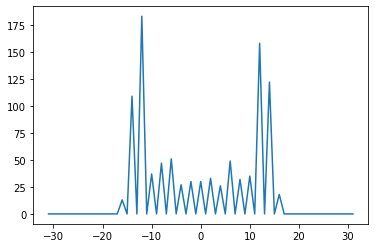

In [47]:
if __name__ == "__main__":
    N=6
    T = 20

    sd = Simulation(T,N,'Hadamard',initial_coin_state = [1/np.sqrt(2),1.j/np.sqrt(2)])

    print(sd)

    pos_x = [i for i in range(-2**(N-1) +1, 2**(N-1))]

    freq_y = [0 for i in range(-2**(N-1) +1, 2**(N-1))]



    # Assign frequencies from Simulation to appropraite posn in freq_y
    for i in list(sd.keys()):
        freq_y[pos_x.index(i)] = sd[i]

    import pandas as pd  

    dict = {'pos': pos_x, 'freq': freq_y}  

    df = pd.DataFrame(dict) 
    filename='BalCQWData{}.csv'.format(T)

    df.to_csv(filename) 

    plt.plot(pos_x, freq_y)